In [1]:
#pip install scanpy

In [2]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the .h5ad file
adata = sc.read_h5ad("All_subset.h5ad")

# Check the structure of the data
print(adata)
print(adata.obs.head())
print(adata.var.head())
print(adata.layers['counts'].shape)


AnnData object with n_obs × n_vars = 21486 × 51734
    obs: 'sample_id', 'batch', 'developmental_stage', 'site', 'gender', 'donor_id', 'platform', 'dataset', 'unit'
    layers: 'counts'
                         sample_id        batch developmental_stage   site  \
CTTACCGAGTCCCACG-13-5  ERS20107612  ERS20107612               11pcw  whole   
TTGGAACGTAGGCTGA-17-5  ERS20107655  ERS20107655                5pcw  whole   
CGCTTCAGTTGAACTC-17-5  ERS20107655  ERS20107655                5pcw  whole   
TCATTACAGATGCGAC-17-5  ERS20107655  ERS20107655                5pcw  whole   
GAATGAACATCGATTG-17-5  ERS20107655  ERS20107655                5pcw  whole   

                       gender   donor_id platform dataset  unit  
CTTACCGAGTCCCACG-13-5    male  HDBR15280     10x5   Peng5  cell  
TTGGAACGTAGGCTGA-17-5  female    BRC2188     10x5   Peng5  cell  
CGCTTCAGTTGAACTC-17-5  female    BRC2188     10x5   Peng5  cell  
TCATTACAGATGCGAC-17-5  female    BRC2188     10x5   Peng5  cell  
GAATGAACATCGATT

In [3]:
# Check the first few gene names
print(adata.var_names[:10])
# List of common human mitochondrial genes
mito_genes = [
    'MT-ATP6', 'MT-ATP8', 'MT-CO1', 'MT-CO2', 'MT-CO3',
    'MT-CYB', 'MT-ND1', 'MT-ND2', 'MT-ND3', 'MT-ND4',
    'MT-ND4L', 'MT-ND5', 'MT-ND6'
]

# Annotate mitochondrial genes in adata
adata.var['mt'] = adata.var_names.isin(mito_genes)

# Check how many mitochondrial genes were identified
print(f"Number of mitochondrial genes found: {adata.var['mt'].sum()}")


Index(['7SK', '7SK-4', '7SK.1', '7SK.2', 'A1BG', 'A1BG-AS1', 'A1CF', 'A2M',
       'A2M-AS1', 'A2ML1'],
      dtype='object')
Number of mitochondrial genes found: 13


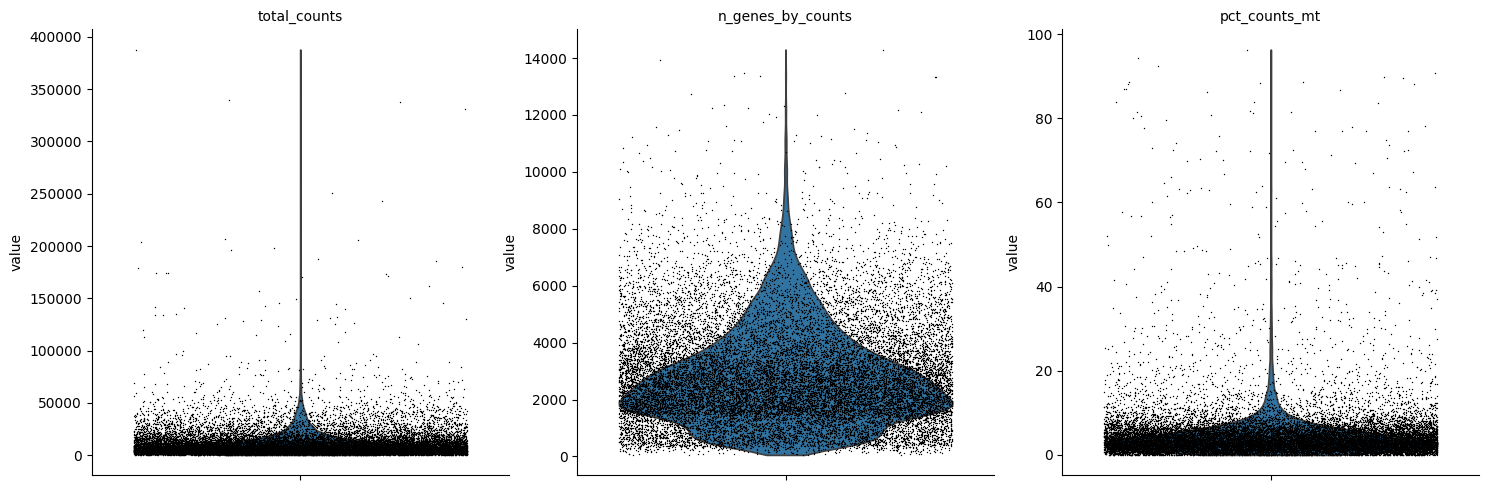

In [4]:
# Calculate QC metrics
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, layer='counts', inplace=True)

# Plot the QC metrics
sc.pl.violin(adata, ['total_counts', 'n_genes_by_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)


In [5]:
# Filter cells
adata = adata[adata.obs['total_counts'] > 1000, :]
adata = adata[adata.obs['pct_counts_mt'] < 5, :]

print(f"Number of cells after filtering: {adata.n_obs}")

#Remove genes that are expressed in fewer than 10 cells.
sc.pp.filter_genes(adata, min_cells=10)
print(f"Number of genes after filtering: {adata.n_vars}")


Number of cells after filtering: 14665


/Users/petra/Desktop/study/UCSF/datasci 223 python/datasci_223/.conda/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:284: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


Number of genes after filtering: 29205


In [6]:
#Normalize counts for each cell and apply log transformation for more stable variance.

sc.pp.normalize_total(adata, target_sum=1e4, layer='counts')

sc.pp.log1p(adata)

In [7]:
#pip install --user scikit-misc

/Users/petra/Desktop/study/UCSF/datasci 223 python/datasci_223/.conda/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


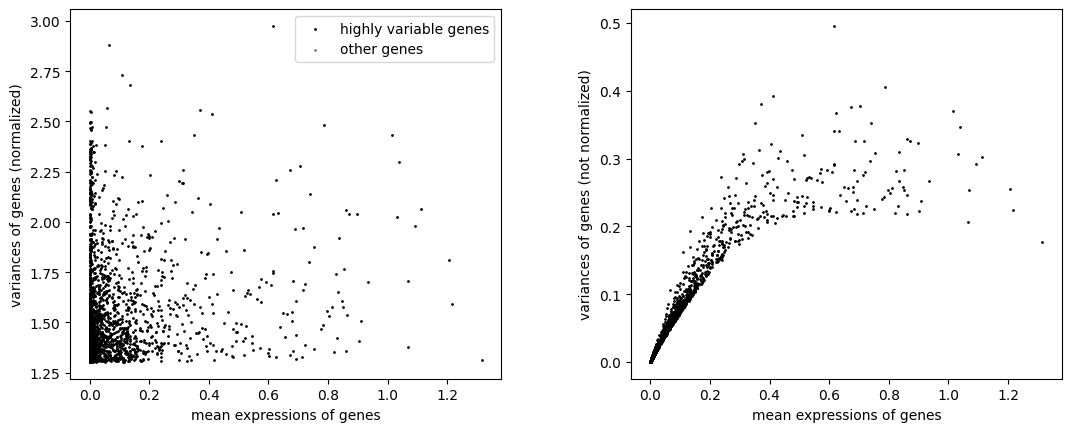

In [8]:
# Identify Highly Variable Genes (HVGs)

sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor='seurat_v3')

# Subset the data to only include HVGs
adata = adata[:, adata.var['highly_variable']]
sc.pl.highly_variable_genes(adata)

/Users/petra/Desktop/study/UCSF/datasci 223 python/datasci_223/.conda/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


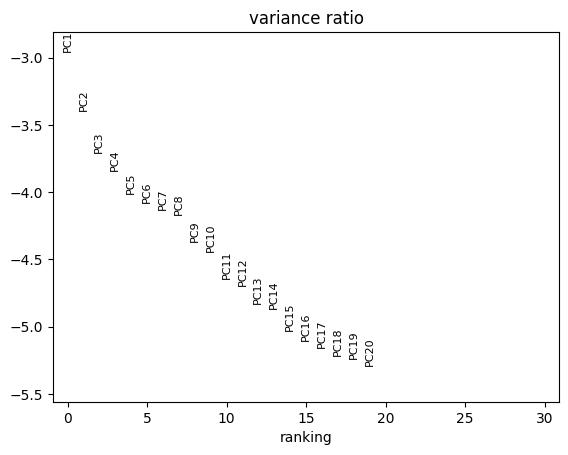

/Users/petra/Desktop/study/UCSF/datasci 223 python/datasci_223/.conda/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


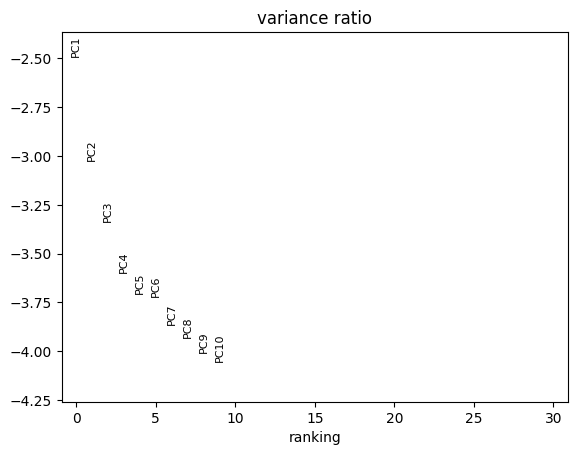

/Users/petra/Desktop/study/UCSF/datasci 223 python/datasci_223/.conda/lib/python3.11/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [ ]:
# Reduce the dimensionality for visualization and clustering. (PCA & UMAP)
# Scale the data and run PCA
sc.pp.scale(adata)
sc.tl.pca(adata, n_comps=20)
sc.pl.pca_variance_ratio(adata, log=True)
# Select highly variable genes before scaling and PCA
sc.pp.highly_variable_genes(adata, flavor='seurat', n_top_genes=100)
adata = adata[:, adata.var['highly_variable']]  # Keep only the highly variable genes

# Scale and run PCA with the reduced set of genes
sc.pp.scale(adata)
sc.tl.pca(adata, n_comps=10)
sc.pl.pca_variance_ratio(adata, log=True)
# Compute the neighborhood graph and run UMAP with fewer parameters
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=5)  # Reduce the n_neighbors and n_pcs
sc.tl.umap(adata)
sc.pl.umap(adata, color=['batch', 'developmental_stage', 'gender'])
# Perform Leiden clustering with a lower resolution and on fewer PCs
sc.tl.leiden(adata, resolution=0.5)
sc.pl.umap(adata, color=['leiden'])
import scipy.sparse as sp

# Convert data to sparse matrix format
adata.X = sp.csr_matrix(adata.X)
